# FarmVibes.AI Nutrients Heatmap

This notebook demonstrates how to run the heatmap workflow on sentinel imagery. The workflow will take field samples for soil properties (such as carbon and nitrogen), and generate an interpolated heatmap based on input imagery.

This workflow ingests user data into the cluster. The reference to the data should be accessible via the internet and, for this demo, we assume it is saved in a remote location such as Azure blob storage.

### Conda environment setup
We provide a conda environment with the package requirements to run this notebook. If you do not have conda installed, please follow the instructions from [Conda User Guide](https://docs.conda.io/projects/conda/en/latest/user-guide/index.html).

The conda environment can be created and activated using the commands below:
```
$ conda env create -f ./nutrients.yaml
$ conda activate nutrients
```

### Useful libraries

Below are the main libraries used for this example and other useful links:
- [NumPy](https://github.com/numpy/numpy) is a python package that provides powerful N-dimensional array object, broadcasting functions and useful linear algebra, Fourier transform, and random number capabilities.
- [pandas](https://github.com/scikit-learn/scikit-learn) is a Python package that provides fast, flexible, and expressive data structures designed to make working with "relational" or "labeled" data both easy and intuitive.
- [rasterio](https://github.com/rasterio/rasterio) is a library for reading and writing geospatial raster data. It is used on torchgeo and rioxarray. It is a good option when reading/writing GeoTIFFs.
- [Scikit-Learn](https://github.com/scikit-learn/scikit-learn) is a Python package for machine learning built on top of SciPy. It Simple and efficient tools for predictive data analysis.
- [Shapely](https://github.com/shapely/shapely) is a library for manipulating geometric shapes.

### Imports & API Client

In [2]:
from datetime import datetime
from vibe_core.client import get_default_vibe_client

from notebook_lib import utils

## Workflow Inputs
The main workflow inputs are as follows:
- [farm_boundary](https://geojson.org/): Boundary of the field in geojson format. It is used to clip the satellite imagery to an area of interest and run the workflow. A sample field boundary is provided in the file `./sensor_farm_boundary.geojson`.
- [geojson_url](https://geojson.org/): Location to the soil sample data. Should be accessible through the internet and will be downloaded in the FarmVibes.AI cluster. The data should contain points and their associated nutrient values. We provide an example in the file `sensor_samples.geojson`. These samples spaced at 50 feet with nutrients information Carbon (C), Phosphorus (P), Nitrogen (N), pH.
- imagery: Satellite imagery with multispectral bands that will be used to generate the heatmap. In this demo we contemplate using Sentinel-2 imagery, which can be ingested by running a FarmVibes.AI workflow or a user provided url.

*Note - The provided sample data (sensor_farm_boundary.geojson, sensor_samples.geojson) is intended to help the user understand how to run the workflow and contains mock data.*

In [6]:
FARM_BOUNDARY = "./sensor_farm_boundary.geojson"
GEOJSON_URL = "<SAS URL>"

## Satellite imagery
Below we outline two methods for getting a raster that contains the satellite imagery used to generate the heatmap. Run the appropriate section below to ingest the data according to your preference.

### 1. Use the FarmVibes.AI workfow
FarmVibes.AI has several workflows that will ingest and preprocess data from many sources. Below we demonstrate how to obtain Sentinel-2 imagery for a desired location (our field boundary) and time range (some time around when the field samples were collected).

In [7]:
START_DATE=datetime(day=30, month=6, year=2022)
END_DATE=datetime(day=2, month=7, year=2022)

In [8]:
# sr_id: EPSG code for the coordinate system (CRS) used in the GeoJSON file
# containing the field boundary
# EPSG:4326 is the WGS-84 CRS (lat-lon) usually used in GeoJSON files
# Change this if your samples are provided in a different (projected) CRS
imagery = utils.get_raster_from_cluster(
    farm_boundary=FARM_BOUNDARY,
    time_range=(START_DATE, END_DATE),
    sr_id=4326
)

Output()

### 2. Ingest user-provided TIFF
Run this if you prefer ingesting your own raster into the cluster in order to use it to compute the heatmap. The raster should include the bands used to compute vegetation-related indices such as Enhanced Vegetation Index (EVI) and Photochemical Reflectance Index (PRI). The band names should be set into the returned `Raster` so the workflow chooses the appropriate bands. Below is an example on how to ingest a Sentinel-2 raster from a user provided URL.

In [12]:
# Url the cluster will use to access the file, e.g., a signed blob URL
IMAGERY_URL = "<SAS URL>"

In [13]:
# Ingest the data into the cluster. A `Raster` is returned
imagery = utils.get_raster_from_external(imagery_url=IMAGERY_URL, farm_boundary=FARM_BOUNDARY)
# Set the bands so that we know which band is what when computing indices
# These are the band names for an L2A Sentinel-2 raster
imagery.bands = {'B01': 0, 'B02': 1, 'B03': 2, 'B04': 3, 'B05': 4, 'B06': 5, 'B07': 6, 'B08': 7, 'B8A': 8, 'B09': 9, 'B11': 10, 'B12': 11}

Output()

## Heatmap workflow
The heatmap workflow will run the following tasks:
- Download sensor samples from the user-provided url. Accuracy of the heatmap will depend on the number of samples.
- Compute vegetation indices from the provided raster.
- Clip index raster and sensor samples using the field boundary.
- Bin sample values.
- Train a spatial interpolation model using the vegetation index as input and the sample bin as output.
- Predict nutrient for the whole region at the raster resolution.
- Generate shapefiles for each bin from the prediction raster.

The workflow can be customized via several parameters, the parameters, default values, and their descriptions can be accessed via the client.

In [3]:
client = get_default_vibe_client()
client.document_workflow("farm_ai/agriculture/heatmap_sensor")

Workflow: farm_ai/agriculture/heatmap_sensor

Description:

It utilize inputs sentinel 2 satellite imagery & the sensor samples as labeled data that contain
    nutrient information (Nitrogen, Carbon, pH, Phosphorus) to train model using Random Forest      
    classifier. The inference operation predict nutrients in soil for chosen farm boundary. The     
    workflow generates a heatmap for selected nutrient. It relies on sample soil data that contain  
    information of nutrients. The quantity of samples define the accuracy of the heat map           
    generation. During the research performed testing with samples spaced at 200 feet, 100 feet and 
    50 feet. The 50 feet sample spaced distance provided results matching to the ground truth.      
    Generating heatmap with this approach reduce the number of samples. It utilizes below logic     
    behind scenes to generate heatmap. - Read the sentinel raster provided. - download sensor       
    samples for the input url provided. - compute indices using the spyndex python package - clip   
    the satellite imagery & sensor samples using farm boundary. - perform spatial interpolation to  
    find raster pixels within the offset distance from sample location and assign the value of      
    nutrients to group of pixels. - classify the data based on number of bins. - train the model    
    using Random Forest classifier. - predict the nutrients using the satellite imagery. - generate 
    a shape file using the predicted outputs.

Sources:

- input_samples (List[vibe_core.data.core_types.ExternalReferenceList]): External references to 
    sensor samples for nutrients.

- input_raster (vibe_core.data.rasters.Raster): Input raster for index computation.

Sinks:

- result (vibe_core.data.core_types.DataVibe): Zip file containing cluster geometries.

Parameters:

- attribute_name (default: C): {'Nutrient property name in sensor samples geojson file. For     
    example': 'CARBON (C), Nitrogen (N), Phosphorus (P) etc.,'}

- buffer (default: 3): Offset distance from sample to perform interpolate operations with       
    raster.

- index (default: ndvi): Type of index to be used to generate heatmap. For example - evi, pri   
    etc.,

- bins (default: 4): possible number of groups used to move value to nearest group using [numpy 
    histogram](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) and to        
    pre-process the data to support model training with classification .

- simplify (default: simplify): Replace small polygons in input with value of their largest     
    neighbor after converting from raster to vector. Accepts simplify or convex or none

- tolerance (default: 1.0): All parts of a [simplified                                          
    geometry](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.simplify.html) 
    will be no more than tolerance distance from the original. It has the same units as the         
    coordinate reference system of the GeoSeries. For example, using tolerance=100 in a projected   
    CRS with meters as units means a distance of 100 meters in reality.

- data_scale (default: False): Accepts True or False. Default is False. On True, it scale data  
    using [StandardScalar]                                                                          
    (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)   
    from scikit-learn package.  It Standardize features by removing the mean and scaling to unit    
    variance.

- distribute_output (default: True): Increases the output variance to avoid output polygon in   
    shape file grouped into single large polygon.

- max_depth (default: 50): The maximum depth of the tree. If None, then nodes are expanded until
    all leaves are pure or until all leaves contain less than min_samples_split samples. For more   
    details refer to                                                                                
    (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

- n_estimators (default: 25): The number of trees in the forest. For more details refer to      
    (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

- random_state (default: 100): Controls both the randomness of the bootstrapping of the samples 
    used when building trees (if bootstrap=True) and the sampling of the features to consider when  
    looking for the best split at each node (if max_features < n_features). For more details refer  
    to                                                                                              
    (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Tasks:

- compute_index: Computes an index from the bands of an input raster.

- download_samples: Adds user geometries into the cluster storage, allowing for them to be used 
    on workflows.

- nutrients: Generate heatmap for nutrients using satellite or spaceEye imagery.

## Generating a Nitrogen heatmap
We demonstrate how to generate a nitrogen heatmap using the Enhanced Vegetation Index (EVI). In the provided sample file, the sensor samples have nitrogen information in attribute "N". Parameters for a workflow run are defined in a dict as shown below.

In [12]:
# input parameters
parameters = {
    "index": "evi",
    "attribute_name": "N",
    "buffer": 3,
    "bins": 4,
    "simplify": "simplify",
    "tolerance": 0.3,
    "data_scale": True,
    "distribute_output": True,
}

archive_path = utils.create_heatmap(
        imagery= imagery, 
        geojson_url = GEOJSON_URL, 
        farm_boundary = FARM_BOUNDARY, 
        parameters = parameters
)

Output()

### Output visualization
We use matplotlib and geopandas to display the results of the workflow from the shapefiles. This is a quick way to get a high level view the workflow output. To get a more detailed look, we recommend opening the generated files and input raster in a geographic analysis platform, such as [QGIS](https://www.qgis.org/en/site/). This will allow you to zoom in and more closely examine the results.

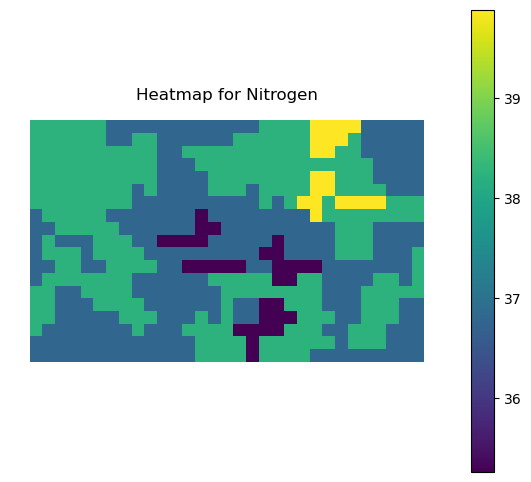

In [13]:
utils.view_output(archive_path, title="Heatmap for Nitrogen")

## Generating a Carbon heatmap
The carbon information is available in the attribute `C`, so we change the parameter accordingly. We also use EVI for this parameter.

In [14]:
# input parameters
parameters = {
    "index": "evi",
    "attribute_name": "C",
    "buffer": 3,
    "bins": 2,
    "simplify": "simplify",
    "tolerance": 0.1,
    "data_scale": False,
    "distribute_output": True
}

archive_path = utils.create_heatmap(
        imagery=imagery, 
        geojson_url = GEOJSON_URL, 
        farm_boundary = FARM_BOUNDARY, 
        parameters = parameters
)

Output()

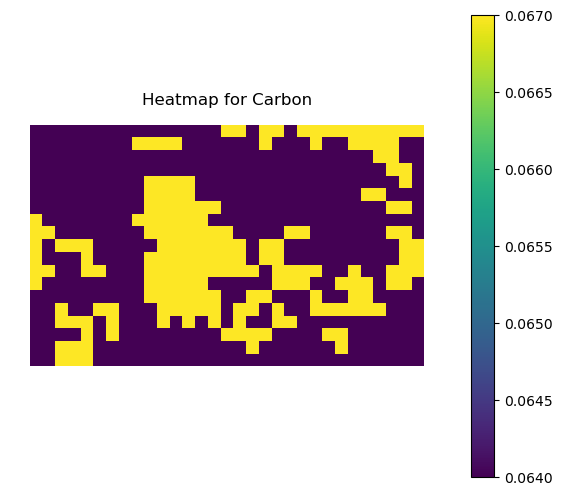

In [15]:
utils.view_output(archive_path, title="Heatmap for Carbon")

## Generating a Phosphorus heatmap
The information about phosphorus is available in the attribute `P`, so we change the parameter accordingly. We also use EVI for this parameter.

In [18]:
# input parameters
parameters = {
    "index":"evi",
    "attribute_name": "P",
    "buffer": 4,
    "bins": 3,
    "simplify": "simplify",
    "tolerance": 0.2,
    "data_scale": True,
    "distribute_output": True
}

archive_path = utils.create_heatmap(
        imagery= imagery, 
        geojson_url = GEOJSON_URL, 
        farm_boundary = FARM_BOUNDARY, 
        parameters = parameters
)

Output()

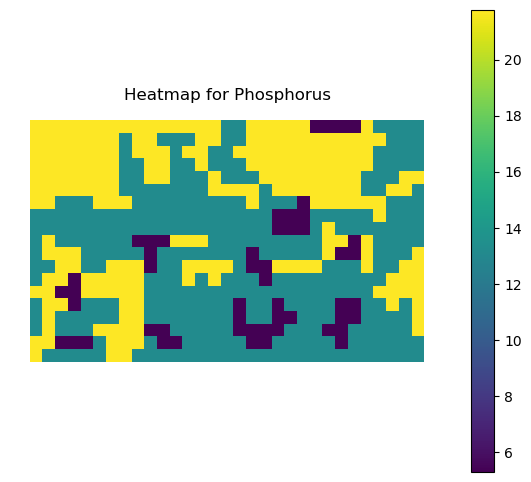

In [19]:
utils.view_output(archive_path, title="Heatmap for Phosphorus")

## Generating a pH heatmap
The information about pH is available in the attribute `pH`, so we change the parameter accordingly. We found that the Photochemical Reflectance Index (PRI) has better correlation with pH values, so we adjust the index as well.

In [20]:
# input parameters
parameters = {
    "index": "pri",
    "attribute_name": "pH",
    "buffer": 3,
    "bins": 2,
    "simplify": "simplify",
    "tolerance": 0.2,
    "data_scale": False,
    "distribute_output": True
}

archive_path = utils.create_heatmap(
        imagery=imagery, 
        geojson_url = GEOJSON_URL, 
        farm_boundary = FARM_BOUNDARY, 
        parameters = parameters
)

Output()

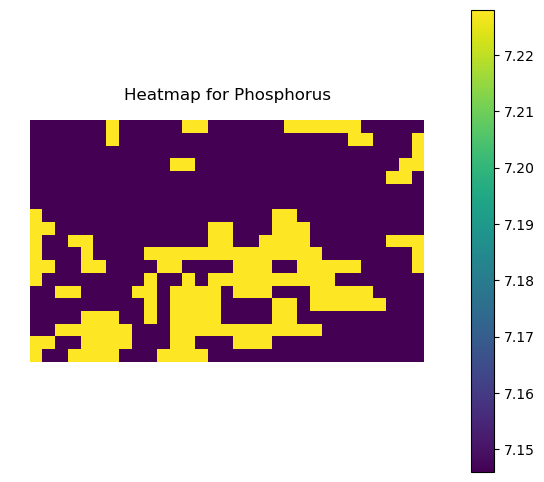

In [21]:
utils.view_output(archive_path, title="Heatmap for Phosphorus")